In [154]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

# import apertls
from matplotlib.colors import LogNorm

import gzip
from typing import Union

import awkward as ak
import pandas as pd

In [78]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta.json')

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [79]:
env = line.env

line['bump.11207'] = 0
line['bump.11407'] = 0
line['bump.11607'] = 0
line['bump.12207'] = 0

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']
line.ref['mdh.12207'].knl[0] += line.vars['bump.12207']

In [80]:
#fix of tidp drift for later insertion of collimator
tt = line.get_table()
tw = line.twiss()
s_start_tidp = line.get_s_position('tidp.11434..0')
line.remove(tt.rows['tidp.*'].name)
line.insert(env.place('tidp.11434', at=s_start_tidp), s_tol=1e-6)

Slicing line:   0%|          | 0/75278 [00:00<?, ?it/s]

In [9]:
line['bump.11207'] = -1.735856e-4
line['bump.11407'] = 7.35268e-5
line['bump.12207'] = 1.603007e-4

In [10]:
tt

Table: 75281 rows, 11 cols
name                             s element_type        isthick isreplica parent_name iscollective ...
sps$start                        0 Marker                False     False None               False
begi.10010                       0 Marker                False     False None               False
qf.10010                         0 Quadrupole             True     False None               False
drift_0..0                   3.085 DriftSlice             True     False drift_0            False
veqf.10010.b_aper           3.2504 LimitEllipse          False     False None               False
drift_0..1                  3.2504 DriftSlice             True     False drift_0            False
veba.10030.a_aper           3.2516 LimitRect             False     False None               False
drift_0..2                  3.2516 DriftSlice             True     False drift_0            False
mba.10030_entry            3.44499 Marker                False     False None          

In [11]:
tt.rows['mdh.12207':'mdh.12207>>50'].show()

name                              s element_type        isthick isreplica parent_name        ...
mdh.12207                    703.43 Multipole             False     False None              
drift_mdh.12207..2..0        703.43 DriftSlice             True     False drift_mdh.12207..2
mdh.12207.b_aper            703.554 LimitRect             False     False None              
drift_mdh.12207..2..1       703.554 DriftSlice             True     False drift_mdh.12207..2
drift_194                   703.555 Drift                  True     False None              
bph.12208..0                 703.58 DriftSlice             True     False bph.12208         
bph.12208.a_aper             703.58 LimitRect             False     False None              
bph.12208..1                 703.58 DriftSlice             True     False bph.12208         
bph.12208.b_aper            703.854 LimitRect             False     False None              
bph.12208..2                703.854 DriftSlice             True   

(-0.05, 0.05)

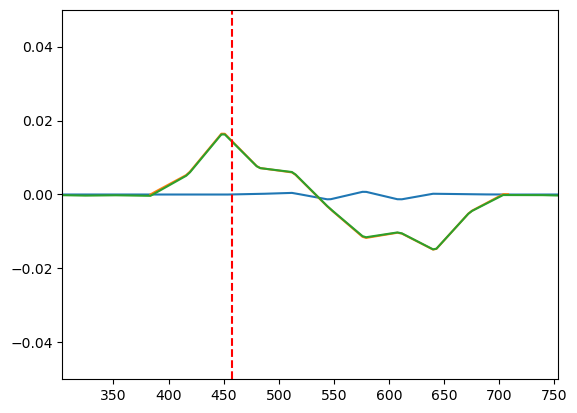

In [12]:
tw_bump = line.twiss(start='mdh.11207', end='mba.12230..0', init=tw)
tw_bump2 = line.twiss()

plt.figure()
plt.plot(tw.s, tw.x)
plt.plot(tw_bump.s, tw_bump.x)
plt.plot(tw_bump2.s, tw_bump2.x)
plt.vlines(s_start_tidp + 4.3, -0.05, 0.05, color='r', linestyle='--')
plt.xlim(s_start_tidp-150, s_start_tidp+300)
plt.ylim(-0.05, 0.05)

In [ ]:
opt = line.match(
    method='6d',
    vary=[
        xt.VaryList(['bump.11207', 'bump.11407', 'bump.11607'], step=1e-8, tag='bump',)
    ],
    targets = [
        xt.Target('x', -21.5e-3, at='tidp.11434'),
        xt.TargetSet(['x', 'px'], value=tw, at='bph.11608..0')
    ]
    )

(-0.0015, 0.001)

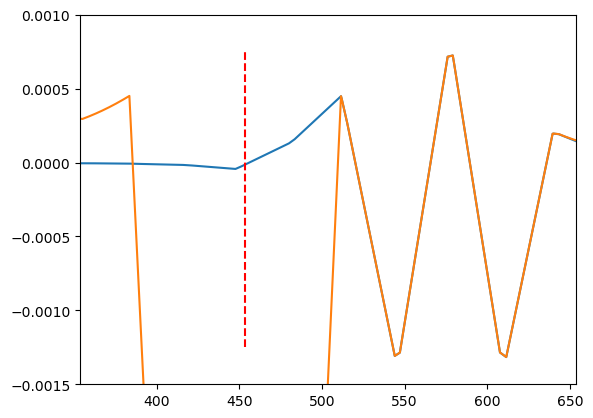

In [83]:
tw2 = line.twiss()
plt.figure()
plt.plot(tw.s, tw.x)
plt.plot(tw2.s, tw2.x)
plt.vlines(s_start_tidp, -0.00125, 0.00075, color='r', linestyle='--')
plt.xlim(s_start_tidp-100, s_start_tidp+200)
plt.ylim(-0.0015,0.001)

In [15]:
line.get_s_position('bph.11608..0')

np.float64(511.5932000000015)

In [16]:
idx_mdh11207 = line.element_names.index('mdh.11207')
idx_mdh11407 = line.element_names.index('mdh.11407')
idx_mdh11607 = line.element_names.index('mdh.11607')
idx_tidp = line.element_names.index('tidp.11434')

opt = line.match(solve=False,
                default_tol={None: 5e-8},
                solver_options=dict(max_rel_penalty_increase=2.),
                init=tw,
                init_at=xt.START,
                start='mba.11190..9',
                end='bph.11608..0',
                #init=tw.get_twiss_init(at_element='mba.11190..9'),
                vary=[
                    xt.VaryList(['bump.11207', 'bump.11407', 'bump.11607'], step=1e-10),
                ],
                targets=[
                    xt.Target('x', at='tidp.11434', value=-30e-3, tol=1e-4),
                    # I want the bump to be closed
                    xt.TargetSet(['x', 'px', 'betx'], value=tw, tol=1e-7, at='mba.11190..9'),
                    xt.TargetSet(['x', 'px', 'betx'], value=tw, tol=1e-7, at='bph.11608..0')
                ]
            )
opt.assert_within_tol=False
opt.restore_if_fail=False


In [17]:
opt.target_status()

Target status:               alty = 2.9815e+00              
id state tag               tol_met       residue   current_val    target_val description                                 
0  ON    tidp.11434_x        False    0.00997171    -0.0200283         -0.03 ('x', 'tidp.11434'), val=-0.03, tol=0.00 ...
1  ON    mba.11190..9_x       True             0  -7.10751e-06  -7.10751e-06 ('x', 'mba.11190..9'), val=-7.10751e-06, ...
2  ON    mba.11190..9_px      True             0  -1.04155e-07  -1.04155e-07 ('px', 'mba.11190..9'), val=-1.04155e-07 ...
3  ON    mba.11190..9_betx    True   2.84217e-14       93.7092       93.7092 ('betx', 'mba.11190..9'), val=93.7092, t ...
4  ON    bph.11608..0_x      False   -0.00682622   -0.00638391   0.000442312 ('x', 'bph.11608..0'), val=0.000442312,  ...
5  ON    bph.11608..0_px     False  -0.000264462  -0.000306581   -4.2119e-05 ('px', 'bph.11608..0'), val=-4.2119e-05, ...
6  ON    bph.11608..0_betx   False       2.97889       105.175       102.197 ('betx',

In [18]:
opt.disable_targets([3,6])

In [19]:
opt.solve()

In [20]:
opt.target_status()

Target status:               nalty = 1.9123e-09              
id state tag               tol_met       residue   current_val    target_val description                                 
0  ON    tidp.11434_x         True   4.92467e-13         -0.03         -0.03 ('x', 'tidp.11434'), val=-0.03, tol=0.00 ...
1  ON    mba.11190..9_x       True             0  -7.10751e-06  -7.10751e-06 ('x', 'mba.11190..9'), val=-7.10751e-06, ...
2  ON    mba.11190..9_px      True             0  -1.04155e-07  -1.04155e-07 ('px', 'mba.11190..9'), val=-1.04155e-07 ...
3  OFF   mba.11190..9_betx    True   2.84217e-14       93.7092       93.7092 ('betx', 'mba.11190..9'), val=93.7092, t ...
4  ON    bph.11608..0_x       True   1.82589e-10   0.000442312   0.000442312 ('x', 'bph.11608..0'), val=0.000442312,  ...
5  ON    bph.11608..0_px      True   5.68468e-12  -4.21189e-05   -4.2119e-05 ('px', 'bph.11608..0'), val=-4.2119e-05, ...
6  OFF   bph.11608..0_betx   False       4.78829       106.985       102.197 ('betx'

In [21]:
tw.dx

array([7.96227824, 7.96227824, 7.96227824, ..., 7.96227825, 7.96227825,
       7.96227825], shape=(75281,))

In [22]:
# tw2 = line.twiss()
tw2.qx

np.float64(20.12519548977536)

# BPM data from xcoll eos

In [7]:
from pathlib import Path

In [8]:
directory_coll = Path('/eos/project-c/collimation-team/acquisition_data/SPS/20250430')

In [41]:
import awkward as ak
import gzip

In [44]:
def smart_open(filepath, mode="rt"):
    filepath = Path(filepath)  # Ensure it's a Path object
    if filepath.suffix == ".gz":
        return gzip.open(filepath, mode)
    else:
        return open(filepath, mode)

def parse_custom_data_file(filename):
    metadata = {}
    data_blocks = []
    current_block = None
    headers = []

    with smart_open(filename) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("@"):
                _, key, type_spec, *value = line.split(maxsplit=3)
                value = value[0] if value else None
                if type_spec == "%d":
                    metadata[key] = int(value)
                elif type_spec == "%f":
                    metadata[key] = float(value)
                elif type_spec == "%s":
                    metadata[key] = value.strip('"')
            elif line.startswith("*"):
                # Start of a new data block
                headers = line[1:].split()
                current_block = []
                data_blocks.append((headers, current_block))
            elif line.startswith("#"):
                continue  # skip comments
            else:
                # Data row
                if current_block is not None:
                    parts = line.split()
                    row = {}
                    for i, header in enumerate(headers):
                        value = parts[i]
                        # Simple type inference
                        try:
                            if "." in value:
                                row[header] = float(value)
                            else:
                                row[header] = int(value)
                        except ValueError:
                            row[header] = value
                    current_block.append(row)

    # Convert to awkward arrays
    awkward_blocks = [ak.Array(block) for _, block in data_blocks]
    return metadata, awkward_blocks


In [45]:
metadata, [monitor_data, corrector_data] = parse_custom_data_file(Path(directory_coll, 'ORBIT_SPSRING_2025-04-30_18-12-49_MD5_CY58_TR0.data.gz'))

In [15]:
h_pos = []
h_rms = []
h_name = []
h_s = []
for arr in monitor_data:
    if arr['PLANE']=='H':
        name = arr['NAME'].lower()
        if name in line.element_dict:
            h_pos.append(arr['POS'])
            h_rms.append(arr['RMS'])
            h_name.append(arr['NAME'])

            rows = tt.rows[f'.*{name}.*']

            if name in rows.name:
                h_s.append(rows.s[np.where(rows.name==name)[0][0]])
            else:
                h_s.append(rows.s[np.where(rows.name==name+'..0')[0][0]])
        else:
            print(name)

bph.41608


In [13]:
tw=line.twiss()

(-0.0001, 0.0001)

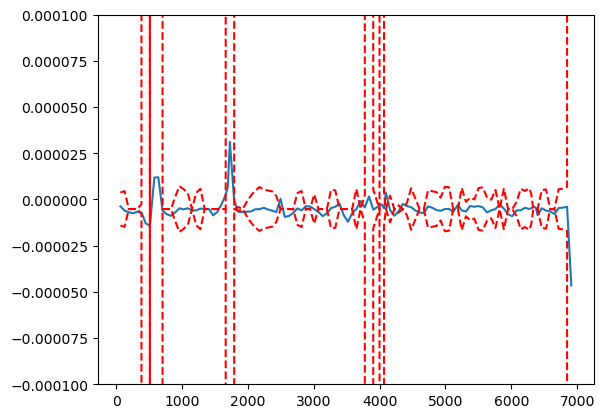

In [38]:
plt.figure()
plt.plot(h_s,np.array(h_pos)*1e-9+ak.mean(tw.x))
#plt.plot(tw.s, tw.x)
plt.plot(h_s, np.array(h_rms)*1e-9+ak.mean(tw.x), 'r--')
plt.plot(h_s, -np.array(h_rms)*1e-9+ak.mean(tw.x), 'r--')
plt.ylim(-1e-4,1e-4)

In [24]:
ak.mean(tw.x)

np.float64(-5.1689662877507255e-06)

In [25]:
ak.std(tw.x)

np.float64(6.59118712109669e-05)

In [ ]:
ak.mean(np.array(h_pos)*1e-9)+ak.mean(tw.x)

np.float64(-5.106950216322154e-06)

In [27]:
ak.std(np.array(h_pos)*1e-9)

np.float64(6.335671815876491e-06)

In [ ]:
line['bph.10208']

View of DriftSlice(parent_name='bph.10208', _parent=Drift(length=0.275), radiation_flag=np.int64(10), delta_taper=0, weight=0.996)

In [22]:
tt.rows['.*.62108.*']

Table: 5 rows, 11 cols
name                         s element_type isthick isreplica parent_name iscollective ...
bpv.62108..0           6431.17 DriftSlice      True     False bpv.62108          False
bpv.62108.a_aper       6431.17 LimitRect      False     False None               False
bpv.62108..1           6431.17 DriftSlice      True     False bpv.62108          False
bpv.62108.b_aper       6431.44 LimitRect      False     False None               False
bpv.62108..2           6431.44 DriftSlice      True     False bpv.62108          False

In [25]:
line['bpv.62108..1']

View of DriftSlice(parent_name='bpv.62108', _parent=Drift(length=0.275), radiation_flag=np.int64(10), delta_taper=0, weight=0.996)

In [24]:
line.twiss()

TwissTable: 75281 rows, 62 cols
name                             s             x            px             y            py ...
sps$start                        0   -1.1268e-05  -2.02305e-07   2.64263e-07  -1.97879e-08
begi.10010                       0   -1.1268e-05  -2.02305e-07   2.64263e-07  -1.97879e-08
qf.10010                         0   -1.1268e-05  -2.02305e-07   2.64263e-07  -1.97879e-08
drift_0..0                   3.085  -1.12656e-05   2.03905e-07   2.16785e-07   -1.1274e-08
veqf.10010.b_aper           3.2504  -1.12318e-05   2.03905e-07    2.1492e-07   -1.1274e-08
drift_0..1                  3.2504  -1.12318e-05   2.03905e-07    2.1492e-07   -1.1274e-08
veba.10030.a_aper           3.2516  -1.12316e-05   2.03905e-07   2.14907e-07   -1.1274e-08
drift_0..2                  3.2516  -1.12316e-05   2.03905e-07   2.14907e-07   -1.1274e-08
mba.10030_entry            3.44499  -1.11922e-05   2.03905e-07   2.12727e-07   -1.1274e-08
mba.10030..entry_map       3.44499  -1.11922e-05   2.0

# Data comparison

## Classes

In [53]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):

    @property 
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        #return self["orbit", "name"]
        return ak.Array([bpm for i, bpm in enumerate(self['name']) if self['plane'][i] == 'H'])
    
    @property
    def bpms_ver(self):
        return ak.Array([bpm for i, bpm in enumerate(self['name']) if self['plane'][i] == 'V'])
    
    def orbit_plane(self, plane: str = "H"):
        if plane == 'H':
            return ak.Array([self['position'][self.index[bpm]] for bpm in self.bpms_hor])
        elif plane == 'V':
            return ak.Array([self['position'][self.index[bpm]] for bpm in self.bpms_ver])
        else:
            ValueError('No valid plane was given !')

    def orbit_position(self, name: str):
        # Return position for a given BPM name
        return self['position'][self.index[name]]
    
    def restr_orbit_plane(self, bpm_list_restr):
        return ak.Array([self['position'][self.index[bpm]] for bpm in bpm_list_restr])

    
    def _build_index(self):
        self._index = {}
        for i, bpm in enumerate(self['name']):
            self._index[bpm] = i
    
    
ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior


In [54]:
class CorrectorsCollectionBehavior(ak.Array):
    @property 
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def corr_hor(self):
        #return self["orbit", "name"]
        return ak.Array([corr for i, corr in enumerate(self['name']) if self['plane'][i] == 'H'])
    
    @property
    def corr_ver(self):
        return ak.Array([corr for i, corr in enumerate(self['name']) if self['plane'][i] == 'V'])
    
    def kick_plane(self, plane: str = "H"):
        if plane == 'H':
            return ak.Array([self['kick'][self.index[corr]] for corr in self.corr_hor])
        elif plane == 'V':
            return ak.Array([self['kick'][self.index[corr]] for corr in self.corr_ver])
        else:
            ValueError('No valid plane was given !')

    def kick_position(self, name: str):
        # Return position for a given BPM name
        return self['kick'][self.index[name]]

    def _build_index(self):
        self._index = {}
        for i, corr in enumerate(self['name']):
            self._index[corr] = i

ak.behavior["*", "CorrectorsCollection"] = CorrectorsCollectionBehavior

In [55]:
def load_bpm_file_data(path: Union[str, Path]) -> ak.Array:
    """
    Load a .data or .data.gz file into an Awkward Array with BPMCollection behavior.
    """

    #file opening with different compression
    path = Path(path)
    opener = gzip.open if path.suffix == ".gz" else open
    with opener(path, "rt") as f:
        lines = f.readlines()

    #Sections of file
    header_lines = []
    orbit_lines = []
    corrector_lines = []

    mode = "header"
    for line in lines:
        if line.startswith("# MONITOR"):
            mode = "orbit"
            continue
        elif line.startswith("# CORRECTOR"):
            mode = "corrector"
            continue

        if mode == "header":
            header_lines.append(line)
        elif mode == "orbit":
            if not line.startswith('*'):
                orbit_lines.append(line)
        elif mode == "corrector":
            if not line.startswith('*'):
                corrector_lines.append(line)

    #Metadata
    meta = {}  # <-- parse @ DATE, @ DPP, etc.
    for line in header_lines:
        if not line.startswith('@'):
            continue
        parts = line.strip().split(maxsplit=3)
        if len(parts) < 4:
            continue
        _, key, dtype, value = parts
        if dtype == "%d":
            value = int(value)
        elif dtype == "%f":
            value = float(value)
        elif dtype == "%s":
            value = value.strip('"')
        meta[key] = ak.Array([value])
    
    
    #Orbit
    orbit = {
        "name": [], "plane": [], "beam": [], "position": [],
        "rms": [], "sum": [], 'hw-status': [], 'status' : [], "status_tag": [],
    }
    # Fill orbit[...] from orbit_lines
    for line in orbit_lines:
        parts = line.strip().split(maxsplit=9)
        assert len(parts)==9
        for i, key in enumerate(list(orbit.keys())):
            value = parts[i]
            # Simple type inference
            try:
                if "." in value:
                    orbit[key].append(float(value))
                else:
                    orbit[key].append(int(value))
            except ValueError:
                if key == 'name':
                    orbit[key].append(value.lower())
                else:
                    orbit[key].append(value)
    
    for key in orbit:
        orbit[key]=ak.Array(orbit[key])
    
    #Correctors
    correctors = {
        "name": [], "plane": [], "beam": [], 'strength_name' : [], "kick": [], "rt_kick": [],
    }
    # Fill correctors[...] from corrector_lines
    for line in corrector_lines:
        parts = line.strip().split(maxsplit=6)
        assert len(parts)==6
        for i, key in enumerate(list(correctors.keys())):
            value = parts[i]
            # Simple type inference
            try:
                if "." in value:
                    correctors[key].append(float(value))
                else:
                    correctors[key].append(int(value))
            except ValueError:
                if key=='name':
                    correctors[key].append(value.lower())
                else:
                    correctors[key].append(value)
    
    for key in correctors:
        correctors[key]=ak.Array(correctors[key])

    #Total dictionary data, idk how to make awkward array out of it
    data = {
        "orbit": ak.Array(orbit, with_name='BPMCollection'),
        "correctors": ak.Array(correctors, with_name='CorrectorsCollection'),
        "meta": ak.Array(meta),
    }

    return data


## Data anaysis

### No bump

In [56]:
directory_coll = Path('/eos/project-c/collimation-team/acquisition_data/SPS/20250430')

In [57]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta.json')

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [63]:
tw = line.twiss()

In [ ]:
data_test = load_bpm_file_data(Path(directory_coll, 'ORBIT_SPSRING_2025-04-30_12-53-55_MD5_CY2_TR0.data.gz'))

In [ ]:
tt=line.get_table()
bpms_hor_in_line = []
s_arr = []
for bpm in data_test['orbit'].bpms_hor:
    if len(tt.rows[f'.*{bpm}.*'].name)>0:
        bpms_hor_in_line.append(bpm)
        if bpm in tt.rows[f'.*{bpm}.*'].name:
            s_arr.append(line.get_s_position(bpm))
        else:
            s_arr.append(line.get_s_position(f'{bpm}..0') + line[f'{bpm}..0']._parent.length/2)

In [140]:
data_with_bump = {
    '12:48' : load_bpm_file_data(Path(directory_coll, 'ORBIT_SPSRING_2025-04-30_12-48-20_MD5_CY5_TR0.data.gz')),
    '13:04' : load_bpm_file_data(Path(directory_coll, 'ORBIT_SPSRING_2025-04-30_13-04-26_MD5_CY6_TR0.data.gz')),
    '13:20:30' : load_bpm_file_data(Path(directory_coll, 'ORBIT_SPSRING_2025-04-30_13-20-32_MD5_CY27_TR0.data.gz')),
}

hor_pos = {time : data_with_bump[time]['orbit'].restr_orbit_plane(bpms_hor_in_line) for time in data_with_bump}

In [113]:
hor_pos = {'12:48' : data_with_bump['12:48']['orbit'].restr_orbit_plane(bpms_hor_in_line),
           '12:55' : data_with_bump['12:55']['orbit'].restr_orbit_plane(bpms_hor_in_line),
           '13:04' : data_with_bump['13:04']['orbit'].restr_orbit_plane(bpms_hor_in_line),
           '13:20:30' : data_with_bump['13:20:30']['orbit'].restr_orbit_plane(bpms_hor_in_line)}

KeyError: '12:55'

(-2e-05, 1e-05)

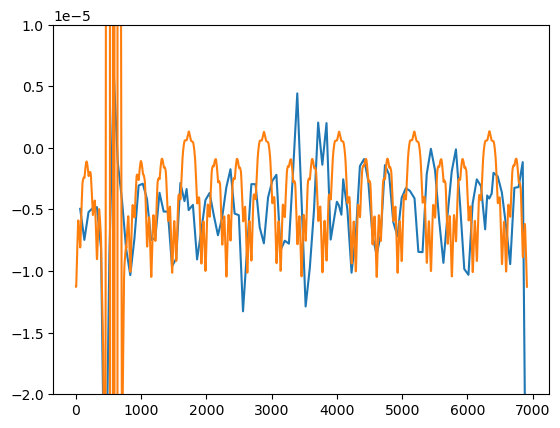

In [74]:
plt.figure()
plt.plot(s_arr, hor_pos*1e-9+ak.mean(tw.x))
plt.plot(tw.s, tw.x)
plt.ylim(-2e-5, 1e-5)

(400.0, 600.0)

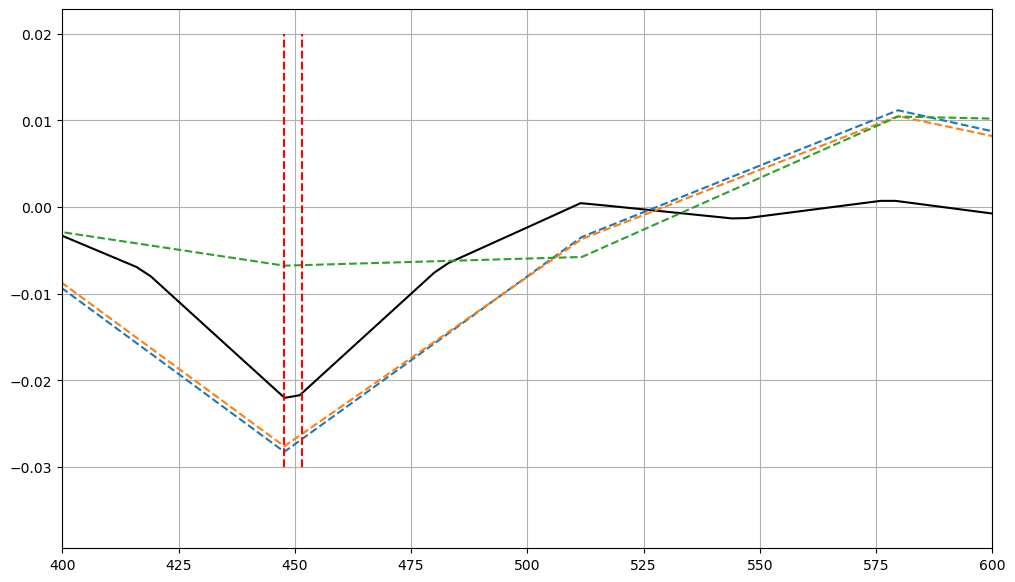

In [144]:
plt.figure(figsize=(12,7))
plt.plot(tw2.s, tw2.x, color='black')

for time in data_with_bump:
    plt.plot(s_arr, hor_pos[time]*1e-6, linestyle='--')

#plt.vlines(s_start_tidp, -0.03, 0.02, color='r', linestyle='--')
# plt.plot(s_arr, hor_pos['12:48']*1e-6, 'g--')
# plt.plot(s_arr, hor_pos['13:04']*1e-6, 'r--')
# plt.plot(s_arr, hor_pos['13:20:30']*1e-6, 'b--')
plt.grid()
plt.vlines(line.get_s_position('bph.11408..0'), -0.03, 0.02, ls = '--', color='red')
plt.vlines(line.get_s_position('tidp.11434'), -0.03, 0.02, ls = '--', color='red')
plt.xlim(400, 600)

In [149]:
np.where(tw2.name=='bph.11408..0')

(array([5226]),)

In [150]:
tw2.x[5226]

np.float64(-0.021896914772171854)

In [148]:
tw2.x[5240]

np.float64(-0.021500000000294218)

# loading all files

In [ ]:

def load_all_bpm_files(directory_coll):
    bpm_files_by_timestamp = {}

    pattern = re.compile(r"ORBIT_SPSRING_(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})_.*\.data\.gz")

    for file in Path(directory_coll).glob("ORBIT_SPSRING_*.data.gz"):
        match = pattern.match(file.name)
        if match:
            timestamp_raw = match.group(1)
            timestamp = timestamp_raw.replace('_', ' ', 1)  # Convert to 'YYYY-MM-DD HH-MM-SS'
            try:
                bpm_files_by_timestamp[timestamp] = load_bpm_file_data(file)
            except (AssertionError, EOFError, OSError, ValueError) as e:
                print(f"Skipping file due to error ({type(e).__name__}): {file}")
                continue

    return bpm_files_by_timestamp

In [108]:
directory_coll = Path('/eos/project-c/collimation-team/acquisition_data/SPS/20250430')

In [131]:
bpm_dict = load_all_bpm_files(directory_coll)

Skipping file due to error (AssertionError): /eos/project-c/collimation-team/acquisition_data/SPS/20250430/ORBIT_SPSRING_2025-04-30_11-25-30_MD5_CY67_TR0.data.gz
Skipping file due to error (AssertionError): /eos/project-c/collimation-team/acquisition_data/SPS/20250430/ORBIT_SPSRING_2025-04-30_11-26-25_MD5_CY69_TR0.data.gz
Skipping file due to error (AssertionError): /eos/project-c/collimation-team/acquisition_data/SPS/20250430/ORBIT_SPSRING_2025-04-30_12-19-47_MD5_CY185_TR0.data.gz
Skipping file due to error (AssertionError): /eos/project-c/collimation-team/acquisition_data/SPS/20250430/ORBIT_SPSRING_2025-04-30_12-20-14_MD5_CY186_TR0.data.gz


In [153]:
bpm_dict.keys()

dict_keys(['2025-04-30_10-26-04', '2025-04-30_10-26-10', '2025-04-30_10-26-37', '2025-04-30_10-27-05', '2025-04-30_10-27-32', '2025-04-30_10-28-28', '2025-04-30_10-28-55', '2025-04-30_10-29-23', '2025-04-30_10-29-50', '2025-04-30_10-30-18', '2025-04-30_10-30-46', '2025-04-30_10-31-13', '2025-04-30_10-31-41', '2025-04-30_10-32-08', '2025-04-30_10-32-36', '2025-04-30_10-33-04', '2025-04-30_10-33-31', '2025-04-30_10-33-59', '2025-04-30_10-34-26', '2025-04-30_10-34-54', '2025-04-30_10-38-35', '2025-04-30_10-39-02', '2025-04-30_10-39-30', '2025-04-30_10-39-58', '2025-04-30_10-40-25', '2025-04-30_10-40-53', '2025-04-30_10-41-20', '2025-04-30_10-41-48', '2025-04-30_10-50-05', '2025-04-30_10-50-32', '2025-04-30_10-51-00', '2025-04-30_10-51-28', '2025-04-30_10-51-55', '2025-04-30_10-52-23', '2025-04-30_10-52-50', '2025-04-30_10-53-18', '2025-04-30_10-53-46', '2025-04-30_10-54-13', '2025-04-30_10-54-41', '2025-04-30_10-55-08', '2025-04-30_10-55-36', '2025-04-30_10-56-04', '2025-04-30_10-56-31', 

In [132]:
hor_pos = {time : bpm_dict[time]['orbit'].restr_orbit_plane(bpms_hor_in_line) for time in bpm_dict}

In [156]:
pd.Timestamp('2025-04-30 10-26-04', tz='Europe/Paris')

Timestamp('2025-04-30 16:00:00+0200', tz='Europe/Paris')

In [157]:
timestamps_md_energy = {26 : {'begin' : [pd.Timestamp('2025-04-30 10:37:41', tz='Europe/Paris'), pd.Timestamp('2025-04-30 12:45:33', tz='Europe/Paris'), 
                                         pd.Timestamp('2025-04-30 14:59:56', tz='Europe/Paris'), pd.Timestamp('2025-04-30 15:07:58', tz='Europe/Paris'),
                                         pd.Timestamp('2025-04-30 17:14:17', tz='Europe/Paris')],
                              'end' : [pd.Timestamp('2025-04-30 12:12:26', tz='Europe/Paris'), pd.Timestamp('2025-04-30 13:29:15', tz='Europe/Paris'), 
                                       pd.Timestamp('2025-04-30 15:06:58', tz='Europe/Paris'), pd.Timestamp('2025-04-30 15:15:00', tz='Europe/Paris'),
                                       pd.Timestamp('2025-04-30 17:54:30', tz='Europe/Paris')]},
                        30 : {'begin' : [pd.Timestamp('2025-04-30 12:15:39', tz='Europe/Paris'), pd.Timestamp('2025-04-30 16:30:39', tz='Europe/Paris')],
                              'end' : [pd.Timestamp('2025-04-30 12:43:15', tz='Europe/Paris'), pd.Timestamp('2025-04-30 17:00:06', tz='Europe/Paris')]}}

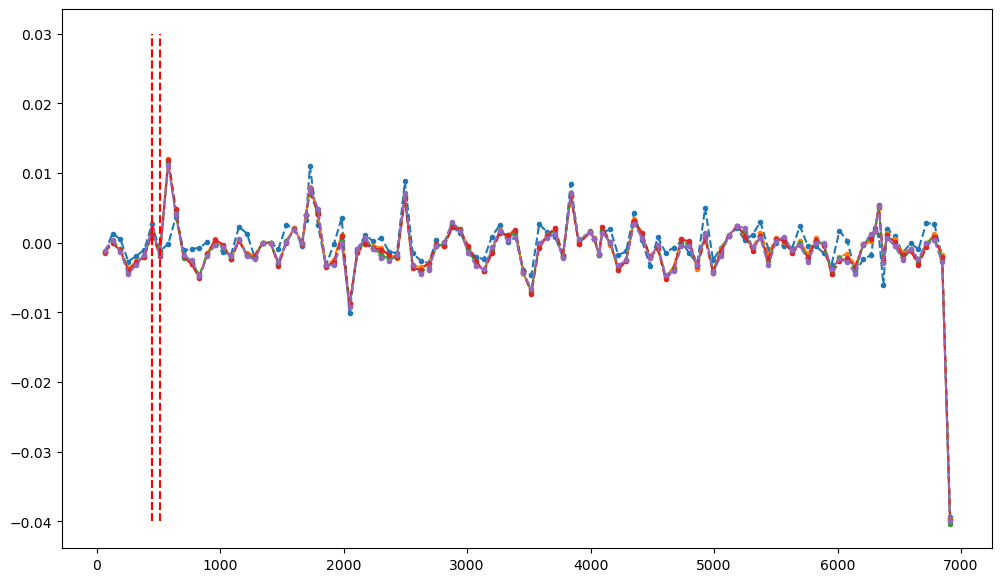

In [138]:
plt.figure(figsize=(12,7))
for time in list(bpm_dict.keys())[:5]:
    plt.plot(s_arr, hor_pos[time]*1e-6,marker='.', linestyle='--')

plt.vlines(line.get_s_position('bph.11408..0'), -0.04, 0.03,ls =  '--', color='red')
plt.vlines(line.get_s_position('bph.11608..0'), -0.04, 0.03, ls = '--', color='red')
plt.vlines(line.get_s_position('tidp.11434'), -0.04, 0.03, ls = '--', color='red')

In [119]:
idx_tidp = line.element_names.index('tidp.11434')

In [125]:
line.element_names[idx_tidp-20:idx_tidp+50]

('drift_mdh.11407..1..1',
 'mdh.11407',
 'drift_mdh.11407..2..0',
 'mdh.11407.b_aper',
 'drift_mdh.11407..2..1',
 'drift_113',
 'bph.11408..0',
 'bph.11408.a_aper',
 'bph.11408..1',
 'bph.11408.b_aper',
 'bph.11408..2',
 'drift_114..0',
 'veqf.11410.a_aper',
 'drift_114..1',
 'qf.11410',
 'drift_115..0',
 'veqf.11410.b_aper',
 'drift_115..1',
 'vmga.11420.a_aper',
 'drift_115..2..0',
 'tidp.11434',
 'drift_1907..1',
 'drift_1908',
 'drift_116..0',
 'vbba.11451.a_aper',
 'drift_116..1',
 'vbba.11451.b_aper',
 'drift_116..2',
 'vcpa.11451.a_aper',
 'drift_116..3',
 'vcpa.11451.b_aper',
 'drift_116..4',
 'vbba.11452.a_aper',
 'drift_116..5',
 'vbba.11452.b_aper',
 'drift_116..6',
 'vcag.11452.a_aper',
 'drift_116..7',
 'vcag.11452.b_aper',
 'drift_116..8',
 'vebb.11470.a_aper',
 'drift_116..9',
 'mbb.11470_entry',
 'mbb.11470..entry_map',
 'mbb.11470..0_aper2',
 'mbb.11470..0_aper2',
 'mbb.11470..0_aper2',
 'mbb.11470..0_aper2',
 'mbb.11470..0_aper2',
 'mbb.11470..0_aper2',
 'mbb.11470..0

In [121]:
line.get_s_position('bph.11408..0')

np.float64(447.5978000000013)

In [122]:
line.get_s_position('tidp.11434')

np.float64(451.4898000000012)

In [126]:
tt = line.get_table()

In [128]:
tt.rows['bph.*'].name

array(['bph.10208..0', 'bph.10208.a_aper', 'bph.10208..1',
       'bph.10208.b_aper', 'bph.10208..2', 'bph.10408..0',
       'bph.10408.a_aper', 'bph.10408..1', 'bph.10408.b_aper',
       'bph.10408..2', 'bph.10608..0', 'bph.10608.a_aper', 'bph.10608..1',
       'bph.10608.b_aper', 'bph.10608..2', 'bph.10808..0',
       'bph.10808.a_aper', 'bph.10808..1', 'bph.10808.b_aper',
       'bph.10808..2', 'bph.11008..0', 'bph.11008.a_aper', 'bph.11008..1',
       'bph.11008.b_aper', 'bph.11008..2', 'bph.11208..0',
       'bph.11208.a_aper', 'bph.11208..1', 'bph.11208.b_aper',
       'bph.11208..2', 'bph.11408..0', 'bph.11408.a_aper', 'bph.11408..1',
       'bph.11408.b_aper', 'bph.11408..2', 'bph.11608..0',
       'bph.11608.a_aper', 'bph.11608..1', 'bph.11608.b_aper',
       'bph.11608..2', 'bph.11831..0', 'bph.11831.a_aper', 'bph.11831..1',
       'bph.11831.b_aper', 'bph.11831..2', 'bph.12008..0',
       'bph.12008.a_aper', 'bph.12008..1', 'bph.12008.b_aper',
       'bph.12008..2', 'bph.122

In [129]:
line.get_s_position('bph.11608..0')

np.float64(511.5932000000015)